In [ ]:
#  look for heteroscedastic datasets in statsmodels

In [1]:
import matplotlib.pyplot as plt

In [2]:
# !pip install patsy
from patsy import dmatrices

In [3]:
# ! pip install statsmodels
import statsmodels.api as sm

In [4]:
cancer_dataset = sm.datasets.cancer.load_pandas()

In [5]:
y, X = dmatrices('cancer ~ population', data=cancer_dataset.data, return_type='dataframe')

In [6]:
X

,Intercept,population
0,1.0,445.0
1,1.0,559.0
2,1.0,677.0
3,1.0,681.0
4,1.0,746.0
...,...,...
296,1.0,62931.0
297,1.0,63476.0
298,1.0,66676.0
299,1.0,74005.0


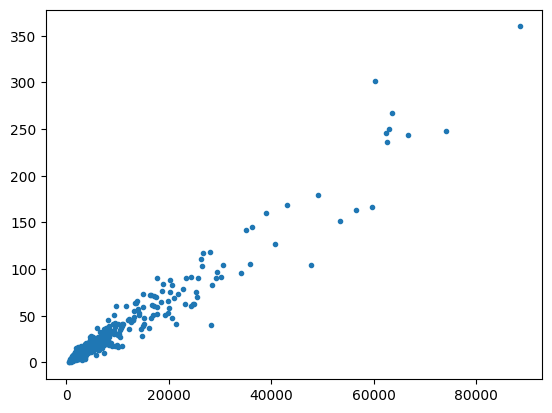

In [7]:
plt.scatter(cancer_dataset.exog, cancer_dataset.endog, marker='.')

In [8]:
# Statistically confirm that the data is heteroscedastic

In [9]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

In [10]:
ols = sm.OLS(y, X)

In [11]:
ols_result = ols.fit()

In [13]:
ols_result.mse_model

729095.9995619444

In [14]:
# residuals of a LM are dependent on X

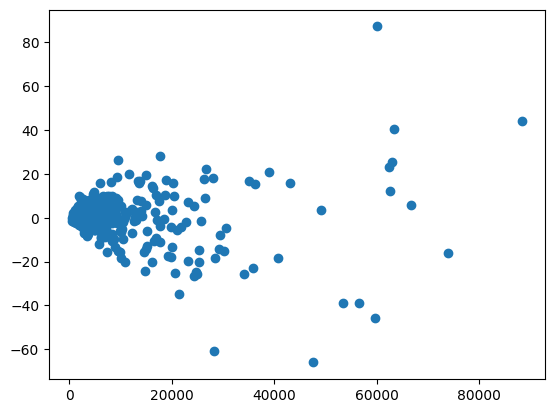

In [15]:
plt.scatter(X.population, ols_result.resid)

In [16]:
# statistical tests confirm this:

In [17]:
het_white(ols_result.resid, X)

(85.53997414283187,
 2.6621383623714153e-19,
 59.154620893488215,
 2.318630760683634e-22)

In [18]:
het_breuschpagan(ols_result.resid, X, robust=False)

(537.3616232659565,
 7.06982038898272e-119,
 117.16552931061003,
 2.9371544178871053e-23)

In [19]:
# Fitting models

In [20]:
# !pip install scikit-learn
import torch
import numpy as np
from sklearn.metrics import r2_score

from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius


In [21]:
torch.set_default_dtype(torch.double)
torch.set_default_tensor_type(torch.DoubleTensor)

/Users/sophiasklaviadis/miniconda3/envs/dsl/lib/python3.10/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [22]:
X_torch = torch.from_numpy(X.to_numpy())[:, 1].unsqueeze(-1)
y_torch = torch.from_numpy(y.to_numpy()).squeeze()

In [23]:
# leave out 10% of the points at the end: extrapolate

In [31]:
n_test = int(.1 * len(X_torch))
X_test, X_train = X_torch[-n_test:], X_torch[:-n_test]
y_test, y_train = y_torch[-n_test:], y_torch[:-n_test]

In [32]:
# normalize inputs
mu = X_train.mean()
std = torch.norm(X_train - mu)

In [33]:
mu

tensor(2.7530)

In [34]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std
X_torch = (X_torch - mu) / std

In [41]:
def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    t = torch.linspace(X_torch.min(), X_torch.max() + .1, len(X_torch)).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(t)
        std_pred = sigma_sq.sqrt()
    
    t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return t, y_pred, a
    

def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
    # Plot the truth
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='train')
    ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

    ax.set_ylim(-10, 370)
    ax.set_xlim(None, t[-1])

def save_for_conf(model):
    alpha = model.alpha
    model.eval()
    
    t_test = torch.linspace(X_test.min(), X_test.max() + .1, len(X_test)).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred_test, sigma_sq_test = model(t_test)
        std_pred_test = sigma_sq_test.sqrt()
    
    t_test = t_test.squeeze().numpy()
    y_pred_test = y_pred_test.squeeze().numpy()
    std_pred_test = std_pred_test.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a_test = 2*std_pred_test
    else:
        # 100% confidence interval.
        R_test = _radius(1, alpha)
        tau_test = (-R_test**2)/2 * (std_pred_test**2) ** (-(alpha-1) / (alpha+1))
        a_test = np.sqrt(-2 * tau_test * std_pred_test**2)

    return y_test, y_pred_test, a_test

In [36]:
# baseline

torch.manual_seed(42)
bl_model = BetaGaussianLM(input_size=1, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.pred_y.weight.data, "b", bl_model.pred_y.bias.data)

R2 train 0.829 test 0.562
w tensor([[330.3561]]) b tensor([26.4945])


In [42]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    torch.manual_seed(42)
    model = BetaGaussianLM(input_size=1, uncertainty=True, heteroscedastic=True, alpha=alpha)
    
    model.pred_y.weight.data[:] = bl_model.pred_y.weight
    model.pred_y.bias.data[:] = bl_model.pred_y.bias
    optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
    
    for epoch in range(n_epochs):
        
        def closure():
            optimizer.zero_grad()
            model.train()
            loss = model.loss(X_train, y_train)
            loss.backward()
            return loss
        
        optimizer.step(closure)
            
    # evaluate R^2
    model.eval()
    y_pred_train = model.predict(X_train).detach().numpy()
    y_pred_test = model.predict(X_test).detach().numpy()
    r2 = "R2 train {:.3f} test {:.3f}".format(
        r2_score(y_pred_train, y_train.numpy()),
        r2_score(y_pred_test, y_test.numpy()))
    
    print(alpha, r2)    
    results.append((alpha, save_for_plot(model), r2))
    np.savetxt(f"cancer_{alpha}_{r2}.csv", save_for_conf(model), delimiter=",")

1 R2 train 0.844 test 0.668
1.3333333333333333 R2 train 0.846 test 0.684
1.5 R2 train 0.848 test 0.694
2 R2 train 0.850 test 0.721


In [38]:
results

[(1,
  (array([-0.06969124, -0.06647558, -0.06325993, -0.06004427, -0.05682861,
          -0.05361295, -0.05039729, -0.04718163, -0.04396598, -0.04075032,
          -0.03753466, -0.034319  , -0.03110334, -0.02788768, -0.02467203,
          -0.02145637, -0.01824071, -0.01502505, -0.01180939, -0.00859374,
          -0.00537808, -0.00216242,  0.00105324,  0.0042689 ,  0.00748456,
           0.01070021,  0.01391587,  0.01713153,  0.02034719,  0.02356285,
           0.0267785 ,  0.02999416,  0.03320982,  0.03642548,  0.03964114,
           0.0428568 ,  0.04607245,  0.04928811,  0.05250377,  0.05571943,
           0.05893509,  0.06215075,  0.0653664 ,  0.06858206,  0.07179772,
           0.07501338,  0.07822904,  0.08144469,  0.08466035,  0.08787601,
           0.09109167,  0.09430733,  0.09752299,  0.10073864,  0.1039543 ,
           0.10716996,  0.11038562,  0.11360128,  0.11681693,  0.12003259,
           0.12324825,  0.12646391,  0.12967957,  0.13289523,  0.13611088,
           0.1393265

Text(0.5, 0, 'Standardized county population')

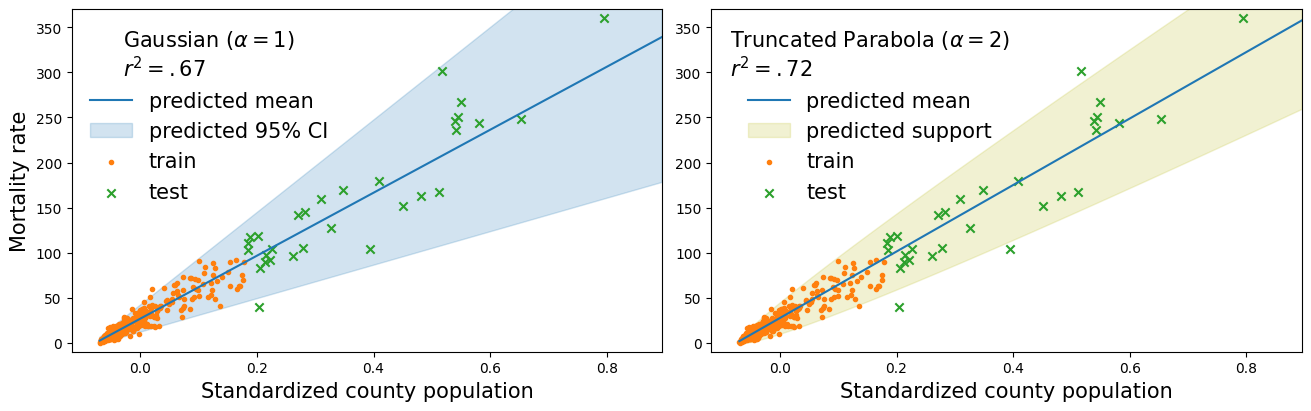

In [39]:
fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plot_model(*results[0][1], ax_gauss, "95% CI", fill_color='C0')
plot_model(*results[3][1], ax_tp, "support", fill_color='C8')
ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2=.67$", fontsize=15)
ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2=.72$", fontsize=15)
ax_gauss.set_ylabel("Mortality rate", fontsize=15)
ax_gauss.set_xlabel("Standardized county population", fontsize=15)
ax_tp.set_xlabel("Standardized county population", fontsize=15)
# plt.savefig("heteroscedastic.pdf")